# Simulations initiated on a seed should be allowed to complete, otherwise plots might not be representative.

In [43]:
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm.notebook import tqdm
from time import time
import numpy as np

In [44]:
def get_dfs(periods=None,
            seeds=None,
            mode=None,
            arms=None,
            experts=None,
            decays=False,
            minimize_seeds=False,
            algorithms=None,
            algs_only=False,
            minimize=False,
            kind=None,decay_map=None,
            trim_decay_before=True,base='results_period/'):
    data=[]
        
    from p_tqdm import p_umap
    filenames=os.listdir(base)
    np.random.shuffle(filenames)
    printed_algs=True
    def parse_file(filename):
        import pandas as pd
        import numpy as np
        if kind is not None and (('perlin' not in filename)==(kind=='perlin')):
            
            return None
        file_kind='regression' if 'perlin' in filename else 'classification'
        is_rect = 'rect' in filename
        smoothness = filename.split("_")[-1]
        info = filename.replace("_"+smoothness,"").split("_")
        extension = "."+filename.split(".")[-1]
        smoothness=float(smoothness.replace(extension,""))
        file_seed  = int(filename.split("_")[1])
        if seeds is not None and file_seed not in seeds:
            
            return None
        K,N = map(int,filename.split("_")[2:4])
        if arms is not None and K not in arms:
            
            return None
        if experts is not None and N not in experts:
            
            return None
        if mode is not None and mode!=smoothness:
            
            return None
        
        file_period = (info[-1].split(".")[0])
        file_period = int(file_period) if file_period!='static' else file_period
        
        if periods is not None and file_period not in periods:
            
            return None
        file_df = pd.read_feather(base+filename)
     
        file_df.algorithm = file_df.algorithm.apply(
                lambda s:s.replace('alpha=1,','').replace("adaptive","ad").replace("beta=","B=").replace("aexpl","a").replace("False","F").replace("True","T"))
        
        assert not np.isnan((file_df[file_df.decay>0].t).values[0])
        file_df.algorithm = file_df.algorithm.str.replace("\(decay","decay")
       
        if trim_decay_before:

            file_df.algorithm = file_df.algorithm.apply(
                lambda s:s.split("decay=")[0])
      
      
        if decays is True:
            file_df = file_df[file_df.decay.isin(file_df.decay.unique()[::2])]
      
      
        if algorithms is not None:
            file_df = file_df[file_df.algorithm.isin(algorithms)]
      
      
        if decay_map is not None:
            def filter_fn(row):
                
                return row['algorithm'].split("decay=")[0] in decay_map and row['decay'] in decay_map[row['algorithm'].split("decay=")[0]]
            file_df = file_df[file_df.apply(filter_fn, axis=1)    ]
     
     
        if algs_only:
            file_df = file_df[(~file_df.algorithm.str.contains("expert"))&(~file_df.algorithm.str.contains("optimal"))&(~file_df.algorithm.str.contains("random"))]
        
        file_df = file_df[file_df.decay<1]
    
    
        if minimize:
            file_df = file_df.groupby(by=['algorithm', 'type', 'n_arms',
                   'n_experts',   'period',
                   'decay', 'problem']).mean().reset_index()
                   
        if minimize_seeds:
            file_df = file_df.groupby(by=['algorithm', 'type', 'n_arms','t',
                   'n_experts',  'period',
                   'decay', 'problem']).mean().reset_index()
        file_df['smoothness']=smoothness
        
    
        return file_df 
    data = p_umap(parse_file,filenames,smoothing=0,desc="reading files")
    # data = map(parse_file,filenames)

    return [d for d in  data if d is not None]

In [45]:

all_data = get_dfs(periods=['static'],arms=None,experts=None,algs_only=False,
                   minimize=True,seeds=np.arange(200),decays=False,
                   algorithms=None)


df = pd.concat(all_data)
best_expert_perf = df[df.algorithm.str.contains('expert 0')].performance.mean()
performance_values = df[df.algorithm.str.contains('expert 0')].groupby('problem').mean().sort_values(by="problem").performance.values
if len(performance_values)<2:
    best_expert_class = best_expert_regr = best_expert_perf
else:
    best_expert_class,best_expert_regr = performance_values
df = None
all_data=None
best_expert_perf,best_expert_class,best_expert_regr

reading files:   0%|          | 0/37 [00:00<?, ?it/s]

(0.786328125, 0.786328125, 0.786328125)

In [46]:
figure_dir = 'figures'
os.makedirs(figure_dir,exist_ok=True)

## Performance by adaptiveness (Figure 2)

reading files:   0%|          | 0/37 [00:00<?, ?it/s]

Best decays:
D-TS decay 0.024236636903652096 performance 0.5867534722222223
EXP4.S decay 0.024236636903652096 performance 0.7014149305555556
D-Meta-CMAB decay 0.15037812951026458 performance 0.8358246527777777


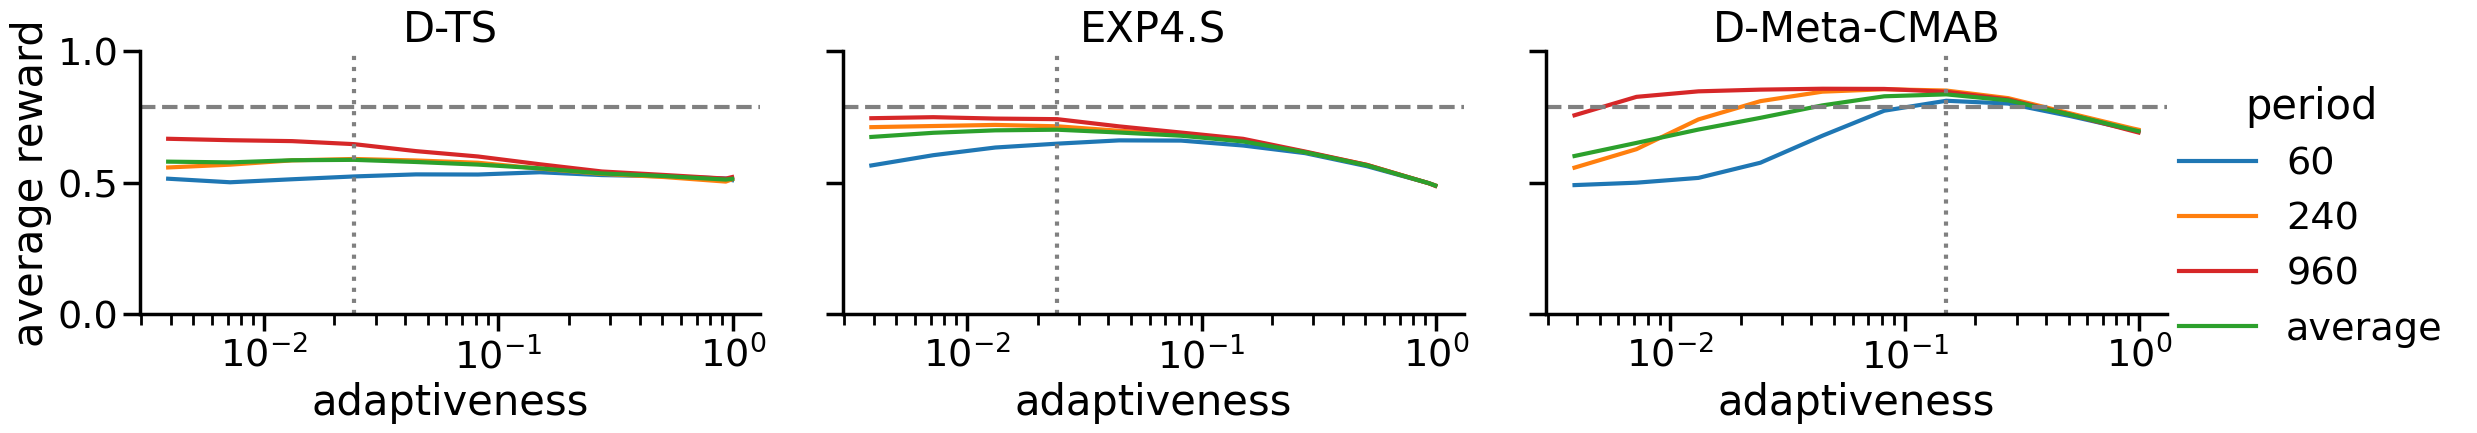

In [47]:
decay_map={'expert 0':[0,0]}

sns.set_context('poster', font_scale=1.25)

algs = ['D-TS','EXP4.S','D-Meta-CMAB']
algs=None
all_data = get_dfs(periods=[60,240,960],arms=None,experts=None,algs_only=True,
                   minimize=True,seeds=np.arange(200),decays=False,
                   algorithms=algs)

all_df = pd.concat(all_data)

algs = ['D-TS','EXP4.S','D-Meta-CMAB']
all_df['k_n']= all_df['n_arms'].astype(str) + ', ' + all_df['n_experts'].astype(str)

all_df = all_df[['algorithm', 'type','k_n',  'period',
       'decay', 't', 'experiment', 'performance', 'smoothness',
       'problem']]
df=all_df

df = df[(df.decay>0)]

palette={'Average':'C1','EXP4.S':'C0','Meta-CMAB':'C2','SW-UCB':'C3','D-TS':'C4','DecisionTreeRegressor':'C5','Ridge':'C6','KernelRidge':'C7','SquareCB':'C9'
         ,'optimal':'grey','random':'red'}


sub_df = df
sub_df = sub_df.groupby(['algorithm','type','k_n','period','decay','smoothness','problem']).mean().reset_index()
sub_df = sub_df[~np.isnan(sub_df.performance)]
sub_df = sub_df.groupby(['algorithm','type','period','decay','smoothness','problem']).mean().reset_index()
sub_df = sub_df[~np.isnan(sub_df.performance)]
new_df = sub_df[sub_df.period!='average'].groupby([c for c in sub_df.columns if c not in ['period','performance','experiment']]).mean().reset_index()

new_df.period='average'

sub_df = sub_df.append(new_df)
sub_df=  sub_df.reset_index()
g = sns.relplot(data=sub_df[sub_df.decay>0],ci=None,aspect=1.5,y="performance",x="decay",hue="period",
                hue_order =[60,240,960,'average'],palette=['C0','C1','C3','C2'],
                col_order=algs,col='algorithm',kind="line",markers='.')
print("Best decays:")


for row in (g.axes):
    for col in (row):
        algorithm=col.get_title().replace("algorithm = ","")

        col.set_title(algorithm )
        
        best_decay  = sub_df[(sub_df.algorithm==algorithm)&(sub_df.period=='average')].groupby(by="decay").mean().reset_index().sort_values(by='performance').iloc[-1].decay
        best_perf = sub_df[(sub_df.algorithm==algorithm)&(sub_df.period=='average')].groupby(by="decay").mean().reset_index().sort_values(by='performance').iloc[-1].performance
        decay_map[algorithm]=[0,best_decay]
        col.axhline(best_expert_perf,c='grey',linestyle='--')
        
        col.axvline(best_decay,c='grey',linestyle=':')
        if algorithm in ('optimal',):
                optline=best_perf
                col.axhline(optline,c='grey',linestyle=':')
        print(algorithm,"decay",best_decay,"performance",best_perf)
        
        col.set_xlabel("adaptiveness")
        col.set_ylabel("average reward")
plt.xscale('log')
plt.ylim(0,1)
plt.ylabel("average reward")
plt.savefig(os.path.join(figure_dir,"tuning.pdf"))
plt.show()

## Averaged performance for non-stationary expertise (Figures 3 and 5)

reading files:   0%|          | 0/37 [00:00<?, ?it/s]

reading files:   0%|          | 0/37 [00:00<?, ?it/s]

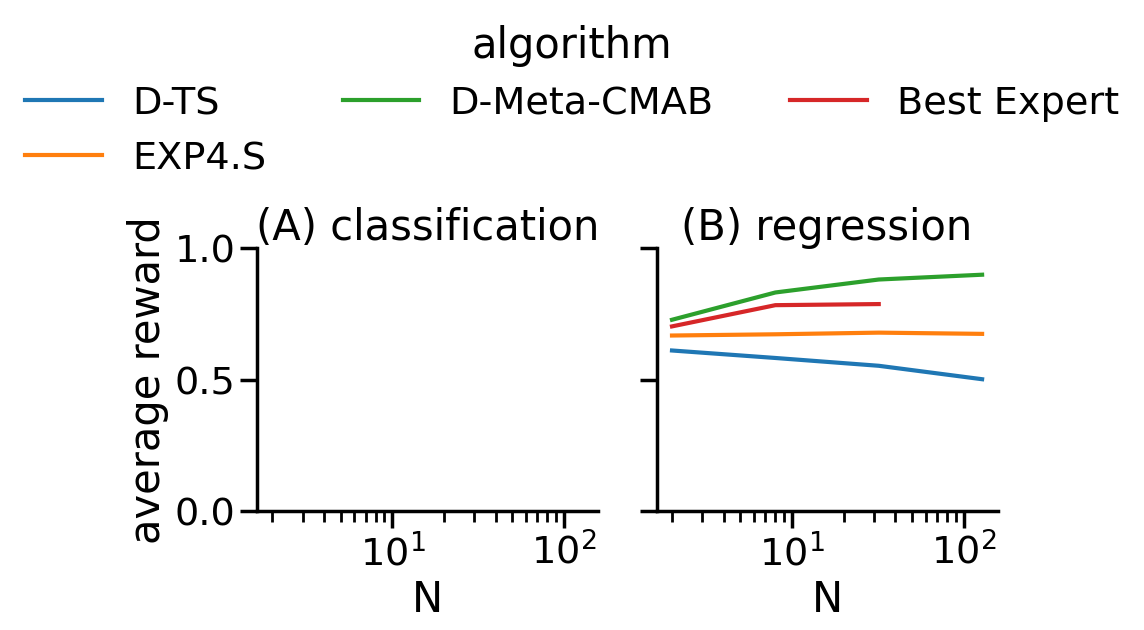

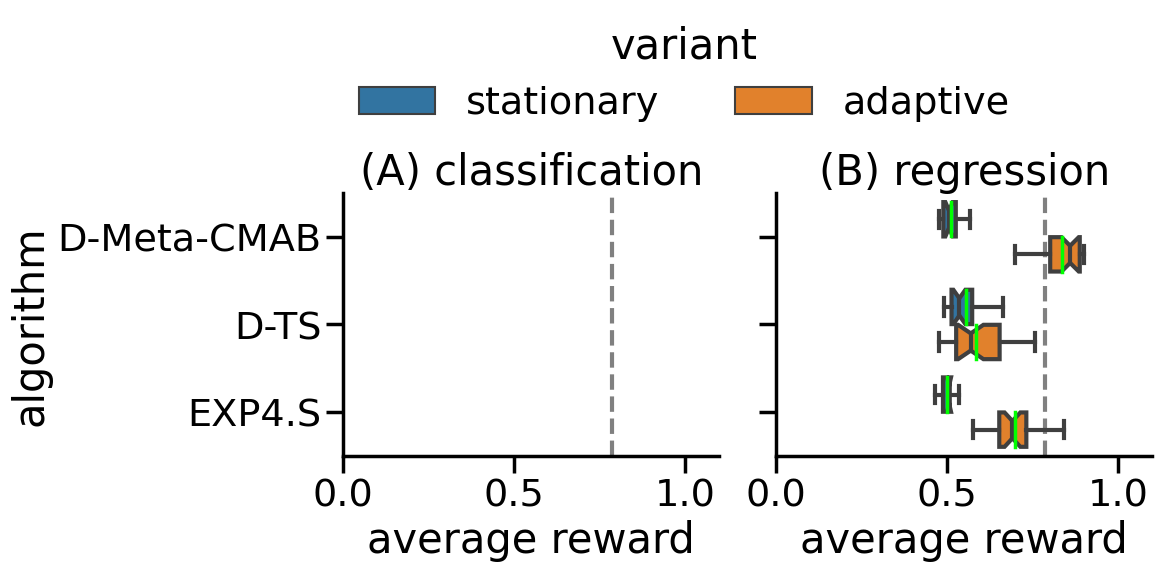

In [48]:

sns.set_context('poster', font_scale=1.25)
mode=None
data = get_dfs(periods=[60,240,960],mode=mode,trim_decay_before=False,
               algs_only=False,minimize=True,seeds=np.arange(200),decays=False,
               algorithms=None,decay_map=decay_map)

data2 = get_dfs(periods=['static'],mode=mode,trim_decay_before=False,algs_only=False,
                minimize=True,seeds=np.arange(200),decays=False,
               algorithms=['expert 0'])

df = pd.concat(data+data2)

df = df[(df.algorithm!='expert 0')|((df.algorithm=='expert 0')&(df.period=='static'))]

def label(row):
    return f'K={row.n_arms}, N={row.n_experts}'

df['k_n'] = df.apply(label,axis=1)
df['K']=df.n_arms
df['N']=df.n_experts
df = df[['algorithm', 'type','k_n','K','N' , 'period',
    'decay', 't', 'experiment', 'performance', 'smoothness',
    'problem']]

df=df[(df.decay>0)|((df.algorithm=='expert 0')&(df.decay==0))]

df.algorithm=df.algorithm.map(lambda s:s.split("decay=")[0])
df.loc[df.algorithm=='expert 0','algorithm']='Best Expert'
algs = ['D-TS','EXP4.S','D-Meta-CMAB','Best Expert']
assert len(df)>0
df['average reward']=df.performance

df = df[~np.isnan(df.performance)]

df.loc[df.period=='static','period']=0
df = df.groupby(['algorithm', 'type', 'k_n', 'K','N' ,
                    'period', 'decay', 't',
        'performance', 'smoothness', 'problem',
    'average reward'],observed=True).mean().reset_index()


df['variant']=df.decay.apply(lambda s:'adaptive' if (s>0) else 'stationary')
col_order=['classification','regression']
assert len(df)>0
for x in ('N',):
    if x=='K':
        g = sns.relplot(data=df[df.N==8],x=x,y='average reward',hue='algorithm',hue_order=algs,
                              col_order=col_order,col='problem',kind='line',aspect=1.,ci=None,)
    else:
        g = sns.relplot(data=df[df.K==8],x=x,y='average reward',hue='algorithm',
                       col_order=col_order,col='problem',kind='line',aspect=1.,ci=None,hue_order=algs,)
    sns.move_legend(g, "lower center", bbox_to_anchor=(.4, .9), ncol=3,  frameon=False)
    for row in g.axes:
        for col,label in zip(row,'ABCD'):
            K=(col.get_title().split("=")[1].strip())
            col.set_title('('+label+') '+K)
    plt.xscale('log')
    plt.ylim(0,1)
    plt.savefig(os.path.join(figure_dir,f"perf_{x}.pdf"), bbox_inches='tight')
    plt.show()
kind=None
mode=None
df = pd.concat(data)


def label(row):
    return f'K={row.n_arms}, N={row.n_experts}'
df['k_n'] = df.apply(label,axis=1)
df = df[[c for c in df.columns if c not in ('n_arms','n_experts')]]

df.algorithm=df.algorithm.map(lambda s:s.split("decay")[0])
    
    
algs = ['D-TS','EXP4.S','D-Meta-CMAB']
df['average reward']=df.performance

df['variant']=df.decay.apply(lambda s:'adaptive' if (s>0) else 'stationary')

col_order=['classification','regression']
df = df.groupby(['algorithm', 'type', 
                 'period', 'decay', 't',
        'performance', 'smoothness', 'problem', 'variant', 'k_n',
   'average reward'],observed=True).mean().reset_index()

g = sns.catplot(data=df[df.algorithm!='expert 0'],x='average reward',y='algorithm',showmeans=True,
                meanprops={'color':'lime','linestyle':'-', 'linewidth':2.5, },showfliers=False,
                meanline=True,hue='variant',kind='box',col='problem',aspect=1.3,col_order=col_order,notch=True)

sns.move_legend(g, "lower center", bbox_to_anchor=(.5, .9), ncol=2,  frameon=False)
for row in g.axes:
    for col,label in zip(row,'ABCD'):
        K=(col.get_title().split("=")[1].strip())
        col.set_title('('+label+') '+K)
        col.set_xlim(0,1.1)
        if 'classification' in K:
            col.axvline(best_expert_class,color='grey',zorder=-1,linestyle='--')

        else:
            col.axvline(best_expert_regr,color='grey',zorder=-1,linestyle='--')
plt.savefig(os.path.join(figure_dir,"adaptive_boxplot.pdf"), bbox_inches='tight')
plt.show()

## Stationary expertise (Figure 6)

reading files:   0%|          | 0/37 [00:00<?, ?it/s]

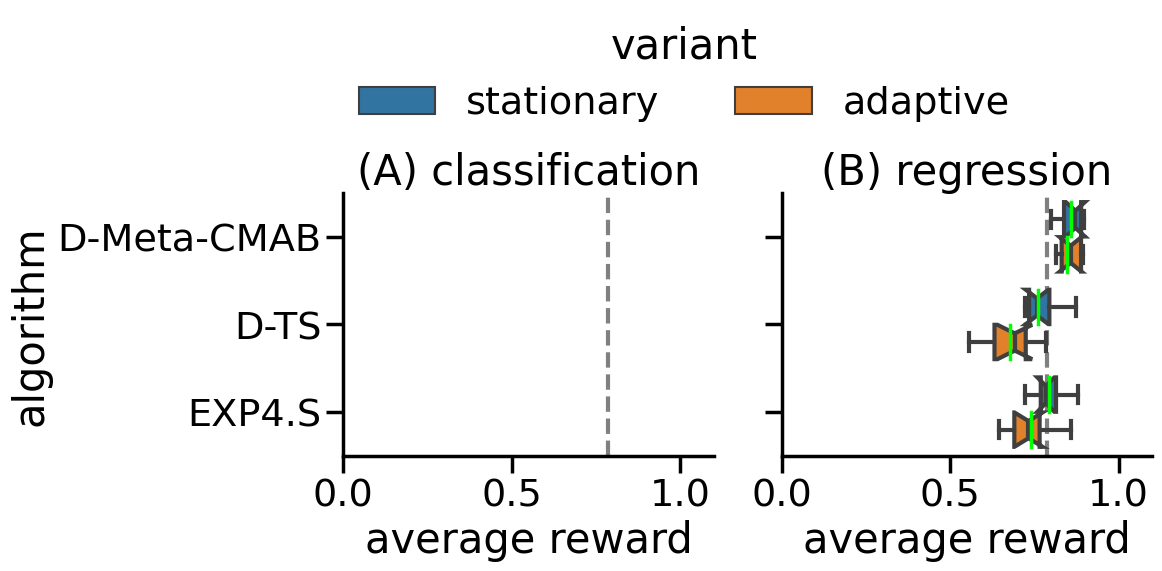

In [49]:
kind=None
sns.set_context('poster', font_scale=1.25)
mode=None
datas = get_dfs(periods=['static'],mode=mode,kind=kind,trim_decay_before=False,
               algs_only=True,minimize=True,seeds=np.arange(200),decays=False,
               algorithms=None,decay_map=decay_map)

df = pd.concat(datas)


def label(row):
    return f'K={row.n_arms}, N={row.n_experts}'
df['k_n'] = df.apply(label,axis=1)
df = df[[c for c in df.columns if c not in ('n_arms','n_experts')]]

df.algorithm=df.algorithm.map(lambda s:s.split("decay")[0])
    
    
algs = ['D-TS','EXP4.S','D-Meta-CMAB']
df['average reward']=df.performance

df['variant']=df.decay.apply(lambda s:'adaptive' if (s>0) else 'stationary')

col_order=['classification','regression']
df = df.groupby(['algorithm', 'type', 
                 'period', 'decay',  't',
        'performance', 'smoothness', 'problem', 'variant', 'k_n',
   'average reward'],observed=True).mean().reset_index()


g = sns.catplot(data=df,x='average reward',y='algorithm',showmeans=True,
                meanprops={'color':'lime','linestyle':'-', 'linewidth':2.5, },showfliers=False,
                meanline=True,hue='variant',kind='box',col='problem',aspect=1.3,col_order=col_order,notch=True)

sns.move_legend(g, "lower center", bbox_to_anchor=(.5, .9), ncol=2,  frameon=False)
for row in g.axes:
    for col,label in zip(row,'ABCD'):
        K=(col.get_title().split("=")[1].strip())
        col.set_title('('+label+') '+K)
        col.set_xlim(0,1.1)
        if 'classification' in K:
            col.axvline(best_expert_class,color='grey',zorder=-1,linestyle='--')

        else:
            col.axvline(best_expert_regr,color='grey',zorder=-1,linestyle='--')
plt.savefig(os.path.join(figure_dir,"stationary_boxplot.pdf"), bbox_inches='tight')
plt.show()

## Performance by timestep (Figure 4)

reading files:   0%|          | 0/37 [00:00<?, ?it/s]

(A)  60 period = 60
(B)  240 period = 240
(C)  960 period = 960
(D)  static period = static


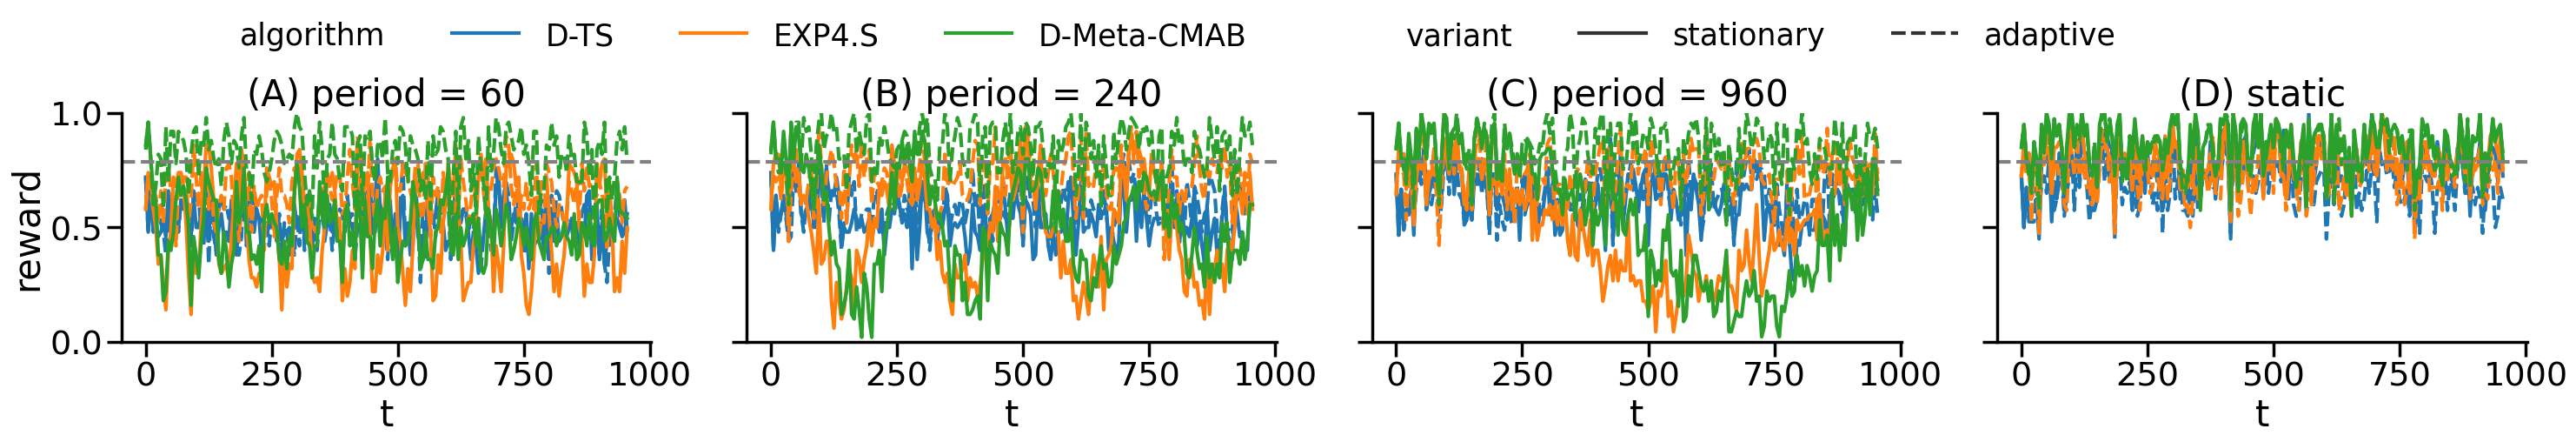

In [50]:
kind=None

data2 = get_dfs(periods=[240,60,960,'static'],mode=None,kind=kind,trim_decay_before=False,
                algs_only=True,minimize=False,minimize_seeds=True,seeds=np.arange(200),decays=False,
               decay_map=decay_map)

df = pd.concat(data2)

df.period = df.period.astype(str)

def label(row):
    return f'K={row.n_arms}, N={row.n_experts}'
df['k_n'] = df.apply(label,axis=1)
df = df.groupby(by=['algorithm', 'type', 't','k_n',
                      'period',"decay",
                  'problem','smoothness'],observed=True).mean().reset_index()

df.algorithm=df.algorithm.map(lambda s:s.split("decay")[0])

algs = ['D-TS','EXP4.S','D-Meta-CMAB']
  
df['average reward']=df.performance

df['variant']=df.decay.apply(lambda s:'adaptive' if (s>0) else 'stationary')
sns.set_context('poster', font_scale=1.25)
col_order=['60','240','960','static']


g = sns.relplot(data=df,x='t',y='average reward',ci=None,hue='algorithm',style='variant',kind='line',col='period',hue_order=algs,
                aspect=1.5,col_order=col_order)

for row in g.axes:
    for col,label in zip(row,'ABCD'):
        print('('+label+') '+col.get_title().replace('period =',''),col.get_title())
        col.set_title('('+label+') '+col.get_title().replace("b'","").replace("'",""))
        if 'static' in col.get_title():
            col.set_title(col.get_title().replace("b'","").replace("period = ","").replace("'",""))
        col.axhline(best_expert_perf,c='grey',linestyle='--')
        col.set_ylim(0,1)
        col.set_ylabel('reward')

sns.move_legend(g, "lower center", bbox_to_anchor=(.4, .9), ncol=10,  frameon=False)
plt.setp(g._legend.get_texts(), fontsize='25')
plt.savefig(os.path.join(figure_dir,"timeplot.pdf"), bbox_inches='tight')
plt.show()